# Correlation Validation (Data From ChatGPT)
Validating the effectiveness of a correlation model is crucial to ensure that the model accurately captures the relationship between tested variables and avoids misleading conclusions. A poorly validated correlation models can lead to false assumptions, the misinterpretation of results, ineffective decision-making, incorrect predictions, and the wasted expenditure of time, energy, labor, and resources.

On the nation-state attack data `nsa_data_v2` aggregated in the `nsa_data_build` notebook, we will perform histogram and Q-Q plot visualizations, statistical normality testing with a variety of methods, and correlation testing with several models such as Spearman's correlation and Kendall's Tau.

The following notebook contains the preliminary analysis of our test data to ensure that the model we chose is the most fitting for our analysis.

## Grabbing our Tools

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

## Getting our Test Data

In [3]:
df = pd.read_parquet('../data/nsa_data_v2.parquet')
df.head()

,attack_name,cve_list_date,date_of_first_exploit,patch_release_date,cvss,cvss_status,days_to_patch_release,days_to_first_exploit,year_start,year_end,attribution_group,attribution_state,cve_id,description
0,BlackEnergy Attack on Ukraine,2014-01-31,2015-12-23,2014-07-01,5.0,medium,151,691,2015,2015,Sandworm,Russia,CVE-2014-0630,EMC Documentum TaskSpace (TSP) 6.7SP1 before P...
1,BlackEnergy Attack on Ukraine,2014-10-07,2015-12-23,2015-01-12,5.0,medium,97,442,2015,2015,Sandworm,Russia,CVE-2014-4166,Cross-site scripting (XSS) vulnerability in th...
2,BlackEnergy Attack on Ukraine,2014-10-14,2015-12-23,2014-12-10,7.5,high,57,435,2015,2015,Sandworm,Russia,CVE-2014-6485,Unspecified vulnerability in Oracle Java SE 8u...
3,BlackEnergy Attack on Ukraine,2015-01-27,2015-12-23,2015-01-27,6.8,medium,0,330,2015,2015,Sandworm,Russia,CVE-2015-0057,win32k.sys in the kernel-mode drivers in Micro...
4,BlackEnergy Attack on Ukraine,2015-04-15,2015-12-23,2015-04-15,7.5,high,0,252,2015,2015,Sandworm,Russia,CVE-2015-1673,The Windows Forms (aka WinForms) libraries in ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   attack_name            87 non-null     category      
 1   cve_list_date          67 non-null     datetime64[ns]
 2   date_of_first_exploit  67 non-null     datetime64[ns]
 3   patch_release_date     67 non-null     datetime64[ns]
 4   cvss                   67 non-null     float64       
 5   cvss_status            67 non-null     category      
 6   days_to_patch_release  67 non-null     Int64         
 7   days_to_first_exploit  67 non-null     Int64         
 8   year_start             80 non-null     Int64         
 9   year_end               80 non-null     Int64         
 10  attribution_group      48 non-null     category      
 11  attribution_state      79 non-null     category      
 12  cve_id                 83 non-null     string        
 13  descrip

## Filter Out Empty Values
Doing the validation won't be possible with empty values in the variables we want to correlate, so I'll filter out the nulls for our columns of interest (`cve_list_date`, `date_of_first_exploit`, `patch_release_date`, `cvss`, `cvss_status`, `days_to_patch_release`, and `days_to_first_exploit`).

In [6]:
df = df[df[[
    'cve_list_date',
    'date_of_first_exploit',
    'patch_release_date',
    'cvss', 'cvss_status'
]].notna().all(axis=1)]

In [7]:
df.head(3)

,attack_name,cve_list_date,date_of_first_exploit,patch_release_date,cvss,cvss_status,days_to_patch_release,days_to_first_exploit,year_start,year_end,attribution_group,attribution_state,cve_id,description
0,BlackEnergy Attack on Ukraine,2014-01-31,2015-12-23,2014-07-01,5.0,medium,151,691,2015,2015,Sandworm,Russia,CVE-2014-0630,EMC Documentum TaskSpace (TSP) 6.7SP1 before P...
1,BlackEnergy Attack on Ukraine,2014-10-07,2015-12-23,2015-01-12,5.0,medium,97,442,2015,2015,Sandworm,Russia,CVE-2014-4166,Cross-site scripting (XSS) vulnerability in th...
2,BlackEnergy Attack on Ukraine,2014-10-14,2015-12-23,2014-12-10,7.5,high,57,435,2015,2015,Sandworm,Russia,CVE-2014-6485,Unspecified vulnerability in Oracle Java SE 8u...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 0 to 85
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   attack_name            67 non-null     category      
 1   cve_list_date          67 non-null     datetime64[ns]
 2   date_of_first_exploit  67 non-null     datetime64[ns]
 3   patch_release_date     67 non-null     datetime64[ns]
 4   cvss                   67 non-null     float64       
 5   cvss_status            67 non-null     category      
 6   days_to_patch_release  67 non-null     Int64         
 7   days_to_first_exploit  67 non-null     Int64         
 8   year_start             60 non-null     Int64         
 9   year_end               60 non-null     Int64         
 10  attribution_group      40 non-null     category      
 11  attribution_state      63 non-null     category      
 12  cve_id                 67 non-null     string        
 13  description 

In [9]:
df.describe()

,cve_list_date,date_of_first_exploit,patch_release_date,cvss,days_to_patch_release,days_to_first_exploit,year_start,year_end
count,67,67,67,67.000000,67.0,67.0,60.0,60.0
mean,2017-08-08 23:38:30.447761152,2018-04-19 16:07:09.850746368,2017-12-24 11:06:16.119403008,8.085075,137.477612,253.686567,2017.85,2017.85
min,2014-01-31 00:00:00,2014-10-01 00:00:00,2014-07-01 00:00:00,5.000000,0.0,-11.0,2015.0,2015.0
25%,2016-02-19 12:00:00,2016-05-22 12:00:00,2016-08-16 12:00:00,7.500000,0.0,113.0,2017.75,2017.75
50%,2017-10-13 00:00:00,2018-05-24 00:00:00,2018-06-27 00:00:00,7.800000,147.0,219.0,2018.0,2018.0
75%,2017-10-17 00:00:00,2018-05-24 00:00:00,2018-06-27 00:00:00,9.550000,253.0,340.0,2018.0,2018.0
max,2022-05-10 00:00:00,2023-04-25 00:00:00,2022-06-06 00:00:00,9.800000,358.0,691.0,2022.0,2022.0
std,NaN,NaN,NaN,1.416168,125.050094,171.529237,1.571192,1.571192


## Verifying Distributive Normalcy
### Histogram Plots
From the looks of the histogram plots, the CVSS scores seem normal (because of the bell curve) but the days to patch and days to exploit don't seem normal; rather, they seem heavily skewed to the right and even bimodal, respectively. We can't rely on appearances alone though, so in the next section, we'll use several statistical tests to verify the data's shape mathematically. The histogram plots are superimposed with a kernel density estimation (KDE) that approximates the shape of the distribution. Taken together, we can see that the test data, though theoretically continuous, has larger gaps where certain potential values are not represented. This makes interpreting the results of the normality testing that follows less accurate since they all expect continuous data. This issue may sufficiently fall away when testing our actual dataset given its larger sample size. Fortunately for now, non-parametric tests like Spearman's correlation and Kendall's Tau can handle discrete variables, but we'll still go through normality testing to verify the discreteness of our current test data.

In [10]:
# Variables to test
cvss = df['cvss']
dtpr = df['days_to_patch_release']
dtfe = df['days_to_first_exploit']

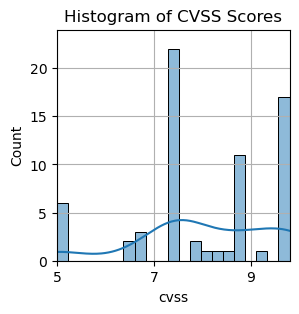

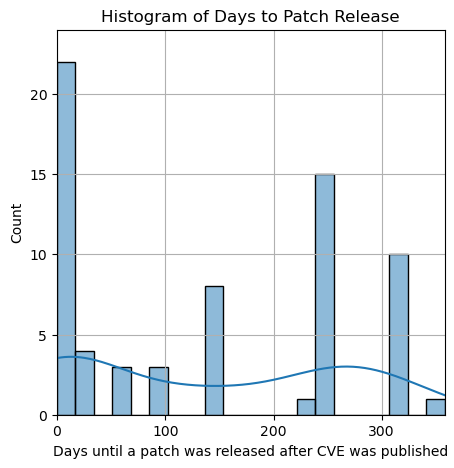

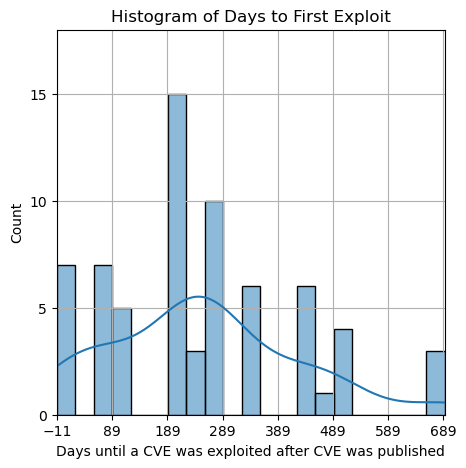

In [11]:
# Visualize normality visually for CVSS
plt.figure(figsize=(3, 3))
sns.histplot(cvss, kde=True, bins=21)
plt.title('Histogram of CVSS Scores')
min_x = cvss.min()
max_x = cvss.max()
plt.xlim(min_x, max_x)
plt.xticks(np.arange(min_x, max_x, 2))
max_y = cvss.value_counts().max() + 3
plt.ylim(0, max_y)
plt.yticks(np.arange(0, max_y, 5))
plt.grid(True)
plt.show()

# Visualize normality visually for CVSS
plt.figure(figsize=(5, 5))
sns.histplot(dtpr, kde=True, bins=21)
plt.title('Histogram of Days to Patch Release')
plt.xlabel('Days until a patch was released after CVE was published')
min_x = dtpr.min()
max_x = dtpr.max()
plt.xlim(min_x, max_x)
plt.xticks(np.arange(min_x, max_x, 100))
max_y = dtpr.value_counts().max() + 3
plt.ylim(0, max_y)
plt.yticks(np.arange(0, max_y, 5))
plt.grid(True)
plt.show()

# Visualize normality visually for CVSS
plt.figure(figsize=(5, 5))
sns.histplot(dtfe, kde=True, bins=21)
plt.title('Histogram of Days to First Exploit')
plt.xlabel('Days until a CVE was exploited after CVE was published')
min_x = dtfe.min()
max_x = dtfe.max()
plt.xlim(min_x, max_x)
plt.xticks(np.arange(min_x, max_x, 100))
max_y = dtfe.value_counts().max() + 3
plt.ylim(0, max_y)
plt.yticks(np.arange(0, max_y, 5))
plt.grid(True)
plt.show()

### Q-Q Plots
Q-Q plots graph the relationship between a variable's empirical distribution against a theoretical distribution (like normality, etc.). They are similar in this was to the Kolmogorov-Smirnov test and they can thus be used to visually gauge the shape of our data. The theoretical distribution of our data will be a $45\degree$ line and our data will be normally distributed if its quantiles fall along this line.

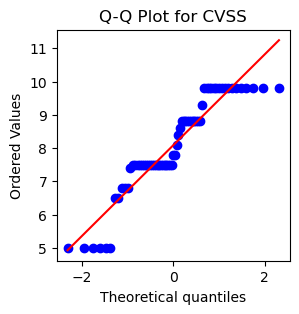

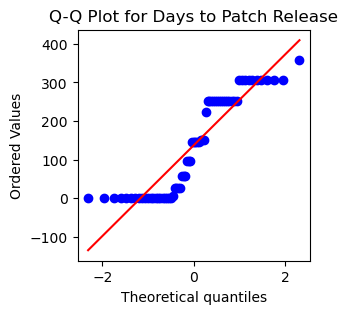

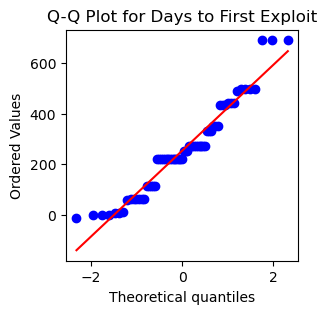

In [12]:
# CVSS Q-Q plot
plt.figure(figsize=(3, 3))
stats.probplot(cvss, dist='norm', plot=plt)
plt.title('Q-Q Plot for CVSS')
plt.show()

# Days to Patch Release Q-Q plot
plt.figure(figsize=(3, 3))
stats.probplot(dtpr, dist='norm', plot=plt)
plt.title('Q-Q Plot for Days to Patch Release')
plt.show()

# CVSS Q-Q plot
plt.figure(figsize=(3, 3))
stats.probplot(dtfe, dist='norm', plot=plt)
plt.title('Q-Q Plot for Days to First Exploit')
plt.show()

There are regions of normality in all three of our variables, but there are also indications of discreteness (plateauing) and outliers that are not well-modeled by a normal distribution. This gives us further indication that the data are not normally distributed, but obviously we can't rely on appearances alone.

### Statistical Tests
We'll make use of three different statistical tests for normality: the **Anderson-Darling**, the **Kolmogorov-Smirnov**, and the **Shapiro-Wilk** tests. All three of these tests assume *continuous*, univariate data with relatively smaller sample sizes. Very large sample sizes may be significantly impacted even by negligible deviations from normality, so the context of what we're testing is crucial to make the final decision.

<span style='color:#ffcc00;text-shadow:0 0 3px #ffcc00;'>! Bootstrap resampling the dataset for tests of normality will not provide any additional information because such resampling will produce exactly the same shape for every resample.</span>

#### Shapiro-Wilk
The Shapiro-Wilk test tests the null hypothesis that a sample $x_1, ..., x_n$ came from a normally distributed population of *continuous* data. The closer the test statistic `W` is to `1`, the closer the data is to a normal distribution, but if the `p` value provided by the test falls below the chosen alpha level (e.g `0.05`), we must reject the null and conclude that the data is not sufficiently normal enough to do correlation testing with Pearson's rank coefficient. If the sample size is sufficiently large, this test may detect other negligent departures from the null hypothesis, meaning further investigation in the form of a Q-Q plot may be advisable to test the effect size of the original test. We may be able to avoid this if multiple normality tests are producing similar results.

The results of our Shapiro-Wilk test can be interpreted as follows: the `cvss` scores are nearly normal, yet this is not a statistically significant result, so we must reject the null. The `days_to_patch_release` are more abnormal and even less statistically significant. The `days_to_first_exploit` are the closest to normal, yet again we must reject the null on account of statistical insignificance.

In [14]:
# Shapiro-Wilk
cvss_stat, cvss_p_value = stats.shapiro(cvss)
cvss_stat, cvss_p_value = round(cvss_stat, 5), round(cvss_p_value, 5)

dtpr_stat, dtpr_p_value = stats.shapiro(dtpr)
dtpr_stat, dtpr_p_value = round(dtpr_stat, 5), round(dtpr_p_value, 5)

dtfe_stat, dtfe_p_value = stats.shapiro(dtfe)
dtfe_stat, dtfe_p_value = round(dtfe_stat, 5), round(dtfe_p_value, 5)

print(f'Shapiro-Wilk Test for CVSS: stat = {cvss_stat}, p-value = {cvss_p_value}')
print(f'Shapiro-Wilk Test for Days to Patch Release: stat = {dtpr_stat}, p-value = {dtpr_p_value}')
print(f'Shapiro-Wilk Test for Days to First Patch: stat = {dtfe_stat}, p-value = {dtfe_p_value}')

Shapiro-Wilk Test for CVSS: stat = 0.88013, p-value = 1e-05
Shapiro-Wilk Test for Days to Patch Release: stat = 0.83094, p-value = 0.0
Shapiro-Wilk Test for Days to First Patch: stat = 0.93871, p-value = 0.00253


#### Anderson-Darling
The Anderson-Darling test is also used to measure the whether *continuous* data comes from a specified distribution (in this case, a normal one). The larger the test statistic (`A`), the further away from normality our data will be. Instead of a `p` value, this `A` statistic is returned with a set of critical values at various significance levels. If the `A` statistic is larger than the critical value for a given significance level, we then reject the null hypothesis that the data are normally distributed. The test is more sensitive to deviations in the tails of skewed data, which might provide some insights in our `Days_To_Patch_Release` variable.

This test produced test statistics that were greater than our given significance of 5% for all three of our variables, indicating that we must reject the null hypothesis that the data in these columns are normally distributed.

In [15]:
# Anderson-Darling
cvss_stat = stats.anderson(cvss, dist='norm')
dtpr_stat = stats.anderson(dtpr, dist='norm')
dtfe_stat = stats.anderson(dtfe, dist='norm')

print(f'Anderson-Darling Test for CVSS: stat = {cvss_stat.statistic:.5f}')
print(f'Critical values (5% / alpha level 0.05): {cvss_stat.critical_values[2]}')
if cvss_stat.statistic > cvss_stat.critical_values[2]:
    print('Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.\n')
else:
    print('The test statistic is less than the critical value at our desired alpha level, therefore we fail to reject the null hypothesis.\n')

print(f'Anderson-Darling Test for CVSS: stat = {dtpr_stat.statistic:.5f}')
print(f'Critical values (5% / alpha level 0.05): {dtpr_stat.critical_values[2]}')
if dtpr_stat.statistic > cvss_stat.critical_values[2]:
    print('Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.\n')
else:
    print('The test statistic is less than the critical value at our desired alpha level, therefore we fail to reject the null hypothesis.\n')

print(f'Anderson-Darling Test for Days to First Exploit: stat = {dtfe_stat.statistic:.5f}')
print(f'Critical values (5% / alpha level 0.05): {dtfe_stat.critical_values[2]}')
if dtfe_stat.statistic > cvss_stat.critical_values[2]:
    print('Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.\n')
else:
    print('The test statistic is less than the critical value at our desired alpha level, therefore we fail to reject the null hypothesis\n')

Anderson-Darling Test for CVSS: stat = 2.59950
Critical values (5% / alpha level 0.05): 0.747
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Anderson-Darling Test for CVSS: stat = 4.41955
Critical values (5% / alpha level 0.05): 0.747
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Anderson-Darling Test for Days to First Exploit: stat = 1.25958
Critical values (5% / alpha level 0.05): 0.747
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.



#### Kolmogorov-Smirnov
The Kolmogorov-Smirnov test compares the empirical distribution of the data to the theoretical distribution (often a normal distribution, but can be any *continuous* distribution). It provides a measure of the largest difference between the two distributions, given by a `D` statistic, and a `p` value that will indicate whether the null hypothesis will be rejected.

The way we can interpret the results of this test is fairly simple: the closer our test stat gets to `1`, the more different from our theoretical distribution the actual distribution is shown to be. In this case, all three variables are statistically significantly different from normality, with our `CVSS` scores being basically *as different as possible*, though this could be the result of inflated deviations due to our test data's discreteness. In other words, this may change on our actual data, but for now they hold true like the nuclear strong force.

In [16]:
# Kolmogorov-Smirnov
cvss_stat, cvss_p_value = stats.kstest(cvss, 'norm')
cvss_stat, cvss_p_value = round(cvss_stat, 5), round(cvss_p_value, 12)

dtpr_stat, dtpr_p_value = stats.kstest(dtpr, 'norm')
dtpr_stat, dtpr_p_value = round(dtpr_stat, 5), round(dtpr_p_value, 12)

dtfe_stat, dtfe_p_value = stats.kstest(dtfe, 'norm')
dtfe_stat, dtfe_p_value = round(dtfe_stat, 5), round(dtfe_p_value, 12)

print(f'Kolmogorov-Smirnov Test for CVSS: stat = {cvss_stat}, p-value = {cvss_p_value}')
print(f'Kolmogorov-Smirnov Test for Days to Patch Release: stat = {dtpr_stat}, p-value = {dtpr_p_value}')
print(f'Kolmogorov-Smirnov Test for Days to First Exploit: stat = {dtfe_stat}, p-value = {dtfe_p_value}')

Kolmogorov-Smirnov Test for CVSS: stat = 1.0, p-value = 0.0
Kolmogorov-Smirnov Test for Days to Patch Release: stat = 0.68657, p-value = 0.0
Kolmogorov-Smirnov Test for Days to First Exploit: stat = 0.9403, p-value = 0.0


## Correlation Testing

All three normality tests show that we must reject the null hypothesis. None of the variables are normally distributed, meaning parametric correlation testing (such as Pearson's rank coefficient) will produce misleadling results. Instead, we'll conduct a series of non-parametric tests whose data can deviate from normality and present itself discretely. We are left with Spearman's rank correlation and Kendall's Tau. Which of these correlation methods to use depends on the number of duplicates that occur in the data as well as the sample size.

In [17]:
num_total_values = len(cvss)

# Determine number of ties in data
num_unique_cvss_values = cvss.nunique()
num_unique_dtpr_values = dtpr.nunique()
num_unique_dtfe_values = dtfe.nunique()

print(f'Total number of values: {num_total_values}')
print(f'Number of unique CVSS values: {num_unique_cvss_values}')
print(f'Number of unique Time to Patch values: {num_unique_dtpr_values}')
print(f'Number of unique Time to Exploit values: {num_unique_dtfe_values}')


if num_unique_cvss_values < num_total_values:
    print(f'There are {num_total_values - num_unique_cvss_values} tied values in "CVSS"')
if num_unique_dtpr_values < num_total_values:
    print(f'There are {num_total_values - num_unique_dtpr_values} tied values in "Days_To_Patch_Release"')
if num_unique_dtfe_values < num_total_values:
    print(f'There are {num_total_values - num_unique_dtfe_values} tied values in "Days_To_First_Exploit"')

Total number of values: 67
Number of unique CVSS values: 12
Number of unique Time to Patch values: 12
Number of unique Time to Exploit values: 19
There are 55 tied values in "CVSS"
There are 55 tied values in "Days_To_Patch_Release"
There are 48 tied values in "Days_To_First_Exploit"


Because of the prevalence of duplicate values in our columns of interest, we'll most likely want to use Kendall's Tau to calculate the correlation between our variables, but I'm going to run tests using Spearman's rank correlation as well to inform a more definitive choice. We also have to think about the sample size of the test versus our final data. Spearman's correlation could be better suited for larger datasets, especially if our larger dataset has less duplicated data. If we really wanted to, we could resample our test data with bootstrapping and then calculate the standard deviation of the correlation coefficients produced by both methods to guage which is more reliable.

In [18]:
# Spearman's Correlation: Test the relationship between CVSS scores and the time to patch
spearman_corr, spearman_p = stats.spearmanr(cvss, dtpr)

# Kendall's Tau: Test the relationship between CVSS scores and the time to patch
kendall_corr, kendall_p = stats.kendalltau(cvss, dtpr)

print(f"Spearman's correlation between CVSS and Days to Patch Release: {spearman_corr}, p-value: {spearman_p}")
print(f"Kendall's Tau correlation between CVSS and Days to Patch Release: {kendall_corr}, p-value: {kendall_p}\n")

# Spearman's Correlation: Test the relationship between CVSS scores and the time to exploit
spearman_corr, spearman_p = stats.spearmanr(cvss, dtfe)

# Kendall's Tau: Test the relationship between CVSS scores and the time to exploit
kendall_corr, kendall_p = stats.kendalltau(cvss, dtfe)

print(f"Spearman's correlation between CVSS and Days to First Exploit: {spearman_corr}, p-value: {spearman_p}")
print(f"Kendall's Tau correlation between CVSS and Days to First Exploit: {kendall_corr}, p-value: {kendall_p}")

Spearman's correlation between CVSS and Days to Patch Release: 0.5757632834725255, p-value: 3.443981821969181e-07
Kendall's Tau correlation between CVSS and Days to Patch Release: 0.3697368607629339, p-value: 0.00013554911409191007

Spearman's correlation between CVSS and Days to First Exploit: -0.3682766275443037, p-value: 0.002167311496876549
Kendall's Tau correlation between CVSS and Days to First Exploit: -0.3035917269680395, p-value: 0.0012179131804597836


Both correlation models show a slight positive relationship between `cvss` and `days_to_patch_release`, but the `p` value indicates that we cannot reject the null hypothesis. We can't be sure that as the criticality of `CVSS` increases, so too does the time it takes for a patch to be delivered. On the other hand, both correlation models do demonstrate a statistically significant negative relationship between `cvss` scores and `days_to_first_exploit`, suggesting that as the criticality goes up, the amount of time it takes for a CVE to be exploited goes down. The next task will be to do a bootstrap resample to calculate the standard deviation of the coefficients across $10,000$ samples in an effort to measure each method's reliability.

In [19]:
# Number of bootstrap iterations to perform
iterations = 10000

# Storage units for both correlation models' coefficients across iterations
spearman_corrs_cvss_dtpr = []
kendall_corrs_cvss_dtpr = []
spearman_corrs_cvss_dtfe = []
kendall_corrs_cvss_dtfe = []

# Storage units for the number of times our correlations were statistically significant across resamplings
spearman_ss_cvss_dtpr = 0
kendall_ss_cvss_dtpr = 0
spearman_ss_cvss_dtfe = 0
kendall_ss_cvss_dtfe = 0

# If we didn't already know (which we do), we'd drop any empty values here and make sure that each variable of interest contain the same number of observations

# Perform bootstrapping
for _ in range(iterations):
    sample_index = np.random.choice(len(cvss), size=len(cvss), replace=True) # Grab as many observations as are in the original sample and create a new sampling with the same amount of observations

    # Grab the values in each column for the specified index
    cvss_sample = cvss.iloc[sample_index]
    dtpr_sample = dtpr.iloc[sample_index]
    dtfe_sample = dtfe.iloc[sample_index]

    # Calculate Spearman and Kendall correlations and p-values
    spearman_corr_cvss_dtpr, spearman_p_cvss_dtpr = stats.spearmanr(cvss_sample, dtpr_sample)
    kendall_corr_cvss_dtpr, kendall_p_cvss_dtpr = stats.kendalltau(cvss_sample, dtpr_sample)
    spearman_corr_cvss_dtfe, spearman_p_cvss_dtfe = stats.spearmanr(cvss_sample, dtfe_sample)
    kendall_corr_cvss_dtfe, kendall_p_cvss_dtfe = stats.kendalltau(cvss_sample, dtfe_sample)

    # Append correlation coefficients to storage units
    spearman_corrs_cvss_dtpr.append(spearman_corr_cvss_dtpr)
    kendall_corrs_cvss_dtpr.append(kendall_corr_cvss_dtpr)
    spearman_corrs_cvss_dtfe.append(spearman_corr_cvss_dtfe)
    kendall_corrs_cvss_dtfe.append(kendall_corr_cvss_dtfe)

    # Count the frequency of p values that show statistical significance
    if spearman_p_cvss_dtpr < 0.05:
        spearman_ss_cvss_dtpr += 1
    if kendall_p_cvss_dtpr < 0.05:
        kendall_ss_cvss_dtpr += 1
    if spearman_p_cvss_dtfe < 0.05:
        spearman_ss_cvss_dtfe += 1
    if kendall_p_cvss_dtfe < 0.05:
        kendall_ss_cvss_dtfe += 1

# Calculate mean and standard deviation of correlation coefficients
mean_spearman_corrs_cvss_dtpr = np.mean(spearman_corrs_cvss_dtpr)
mean_kendall_corrs_cvss_dtpr = np.mean(kendall_corrs_cvss_dtpr)
mean_spearman_corrs_cvss_dtfe = np.mean(spearman_corrs_cvss_dtfe)
mean_kendall_corrs_cvss_dtfe = np.mean(kendall_corrs_cvss_dtfe)

std_spearman_corrs_cvss_dtpr = np.std(spearman_corrs_cvss_dtpr)
std_kendall_corrs_cvss_dtpr = np.std(kendall_corrs_cvss_dtpr)
std_spearman_corrs_cvss_dtfe = np.std(spearman_corrs_cvss_dtfe)
std_kendall_corrs_cvss_dtfe = np.std(kendall_corrs_cvss_dtfe)

print(f"Spearman's correlation between CVSS and Days to Patch Release\nMEAN: {mean_spearman_corrs_cvss_dtpr}\nSTANDARD DEVIATION: {std_spearman_corrs_cvss_dtpr}\n% OF SIGNIFICANT SAMPLES: {round(spearman_ss_cvss_dtpr / iterations, 2) * 100}%\n")
print(f"Kendall's correlation between CVSS and Days to Patch Release\nMEAN: {mean_kendall_corrs_cvss_dtpr}\nSTANDARD DEVIATION: {std_kendall_corrs_cvss_dtpr}\n% OF SIGNIFICANT SAMPLES: {round(kendall_ss_cvss_dtpr / iterations, 2) * 100}%\n")
print(f"Spearman's correlation between CVSS and Days to First Exploit\nMEAN: {mean_spearman_corrs_cvss_dtfe}\nSTANDARD DEVIATION: {std_spearman_corrs_cvss_dtfe}\n% OF SIGNIFICANT SAMPLES: {round(spearman_ss_cvss_dtfe / iterations, 2) * 100}%\n")
print(f"Kendall's correlation between CVSS and Days to First Exploit\nMEAN: {mean_kendall_corrs_cvss_dtfe}\nSTANDARD DEVIATION: {std_kendall_corrs_cvss_dtfe}\n% OF SIGNIFICANT SAMPLES: {round(kendall_ss_cvss_dtfe / iterations, 2) * 100}%\n")

Spearman's correlation between CVSS and Days to Patch Release
MEAN: 0.5683584872030241
STANDARD DEVIATION: 0.0694517353480414
% OF SIGNIFICANT SAMPLES: 100.0%

Kendall's correlation between CVSS and Days to Patch Release
MEAN: 0.3701487894615312
STANDARD DEVIATION: 0.059415522006034796
% OF SIGNIFICANT SAMPLES: 100.0%

Spearman's correlation between CVSS and Days to First Exploit
MEAN: -0.36558453021795745
STANDARD DEVIATION: 0.11932653684720328
% OF SIGNIFICANT SAMPLES: 85.0%

Kendall's correlation between CVSS and Days to First Exploit
MEAN: -0.3033353040282914
STANDARD DEVIATION: 0.0912399612620393
% OF SIGNIFICANT SAMPLES: 90.0%



Similarly to the single test, a series of $10,000$ tests produces consistent results. Their is a slightly positive correlation between `cvss` scores and `days_to_patch_release`, but this correlation is not statistically significant. In addition, There is a statistically significant negative relationship between `cvss` scores and `days_to_first_exploit`. Moreover, the lower standard deviation of Kendall's Tau produced in both relationships suggests that this method is more reliably gauging the correlation between our variables of interest.